# Part 1: Wrangling

In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# toggle off row display limit
pd.set_option("display.max_rows", None)

In [3]:
# toggle on row display limit
pd.reset_option("display.max_rows")

### Problem 1

In [4]:
sqlite_file = "lahman2014.sqlite"
conn = sql.connect(sqlite_file)

In [5]:
# sql code to retrieve the data of interest from the database
teams_query = """
                SELECT 
                    A.yearID, 
                    A.teamID, 
                    franchID,   
                    W, 
                    G, 
                    100*CAST(W AS float)/CAST(G AS float) AS winPercent,
                    payroll
                FROM 
                    Teams A
                INNER JOIN 
                    (SELECT yearID, teamID, SUM(salary) AS payroll FROM Salaries GROUP BY yearID, teamID) B 
                ON
                    A.yearID = B.yearID AND A.teamId = B.teamId
            """

# runs the sql code and stores the data in a dataframe
teams = pd.read_sql(teams_query, conn)

In [6]:
teams

,yearID,teamID,franchID,W,G,winPercent,payroll
0,1985,ATL,ATL,66,162,40.740741,14807000.0
1,1985,BAL,BAL,83,161,51.552795,11560712.0
2,1985,BOS,BOS,81,163,49.693252,10897560.0
3,1985,CAL,ANA,90,162,55.555556,14427894.0
4,1985,CHA,CHW,85,163,52.147239,9846178.0
...,...,...,...,...,...,...,...
853,2014,SLN,STL,90,162,55.555556,120693000.0
854,2014,TBA,TBD,77,162,47.530864,72689100.0
855,2014,TEX,TEX,67,162,41.358025,112255059.0
856,2014,TOR,TOR,83,162,51.234568,109920100.0


I used the `read_sql()` function in Pandas to extract data from the SQLite database and put it into a Pandas database. In my SQL query, I used the `GROUP BY` statement to sum all of the salaries for each team/year combination in the Salaries table, and then used the `INNER JOIN` statement to combine the resulting table with selected data from the Teams table.

As a result of using `INNER JOIN`, team/year combinations that existed in one table but not the other (missing data) were not included in the final table. Therefore the final table does not have any data from before 1985, which is the earliest year of recorded data in the Salaries table.

For both of these tables, when the row exists, all variables in the row seem to exist.

# Part 2: Exploratory Data Analysis

## Payroll Distribution

### Problem 2

In [7]:
# organizes dataframe for analyzing payrolls
payrolls = teams.drop(teams.columns.difference(["yearID", "payroll"]), 1).set_index("yearID")

# removes years before 1985-1989, we're only looking at 1990-2014
payrolls = payrolls.drop(index=[1985, 1986, 1987, 1988, 1989])

In [8]:
payrolls

,payroll
yearID,
1990,14555501.0
1990,9680084.0
1990,20558333.0
1990,21720000.0
1990,9491500.0
...,...
2014,120693000.0
2014,72689100.0
2014,112255059.0


In [9]:
# creates groupby object with the leage's total payrolls for each year
# object can be used to find mean, std deviation, etc of payrolls for each year
payrolls = payrolls.groupby("yearID")
#payrolls = teams.drop(teams.columns.difference(["yearID", "payroll"]), 1).groupby("yearID")

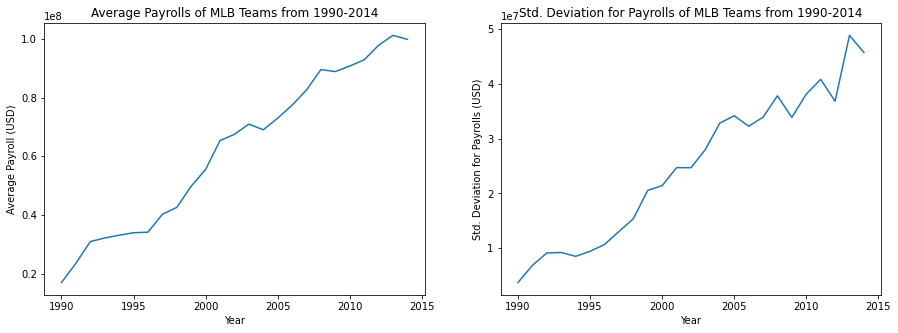

In [10]:
# plots the data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
payrolls.mean().plot(ax=axes[0], legend=False, ylabel="Average Payroll (USD)", 
                     title="Average Payrolls of MLB Teams from 1990-2014")
payrolls.std().plot(ax=axes[1], legend=False, ylabel="Std. Deviation for Payrolls (USD)",
                    title="Std. Deviation for Payrolls of MLB Teams from 1990-2014")
_ = plt.setp(axes, xlabel="Year")

To show the distribution of payrolls across teams conditioned on time I

### Question 1

### Problem 3

In [11]:
#fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 30))
#teams.hist(column="payroll", bins=100, ax=axes[0][0])

# idea: create two histograms, one for payrolls in 1990 and one for payrolls in 2014

## Correlation between payroll and winning percentage

### Problem 4

In [12]:
# puts each index from the teams dataframe in a bin based on its year
years = teams.iloc[:, 0].rename("bin")
bins = pd.cut(x=years, bins=[1990, 1995, 2000, 2005, 2010, 2015], labels=["A", "B", "C", "D", "E"], right=False)

# creates new dataframe with a bin column and select columns from the teams dataframe
means = teams.drop(teams.columns.difference(["teamID", "winPercent", "payroll"]), 1).join(bins)

In [13]:
means

,teamID,winPercent,payroll,bin
0,ATL,40.740741,14807000.0,NaN
1,BAL,51.552795,11560712.0,NaN
2,BOS,49.693252,10897560.0,NaN
3,CAL,55.555556,14427894.0,NaN
4,CHA,52.147239,9846178.0,NaN
...,...,...,...,...
853,SLN,55.555556,120693000.0,E
854,TBA,47.530864,72689100.0,E
855,TEX,41.358025,112255059.0,E
856,TOR,51.234568,109920100.0,E


In [14]:
means = means.groupby(by=["bin", "teamID"]).mean()

In [15]:
means

# some bins have NaN because the teams don't exist in that time period, 
# for example the Diamonbacks (ARI) weren't founded until 1998, so they're NaN in bin A (1990-1994)

winPercent      payroll
bin teamID                         
A   ANA            NaN          NaN
    ARI            NaN          NaN
    ATL      56.497726   31721852.8
    BAL      50.444080   23785204.0
    BOS      49.514761   34863216.8
...                ...          ...
E   SLN      55.679012  104445659.0
    TBA      54.992047   60558982.8
    TEX      53.881694   98567688.2
    TOR      48.888889   87203840.0
    WAS      53.024308   90359804.2

[175 rows x 2 columns]

In [16]:
means = means.dropna()

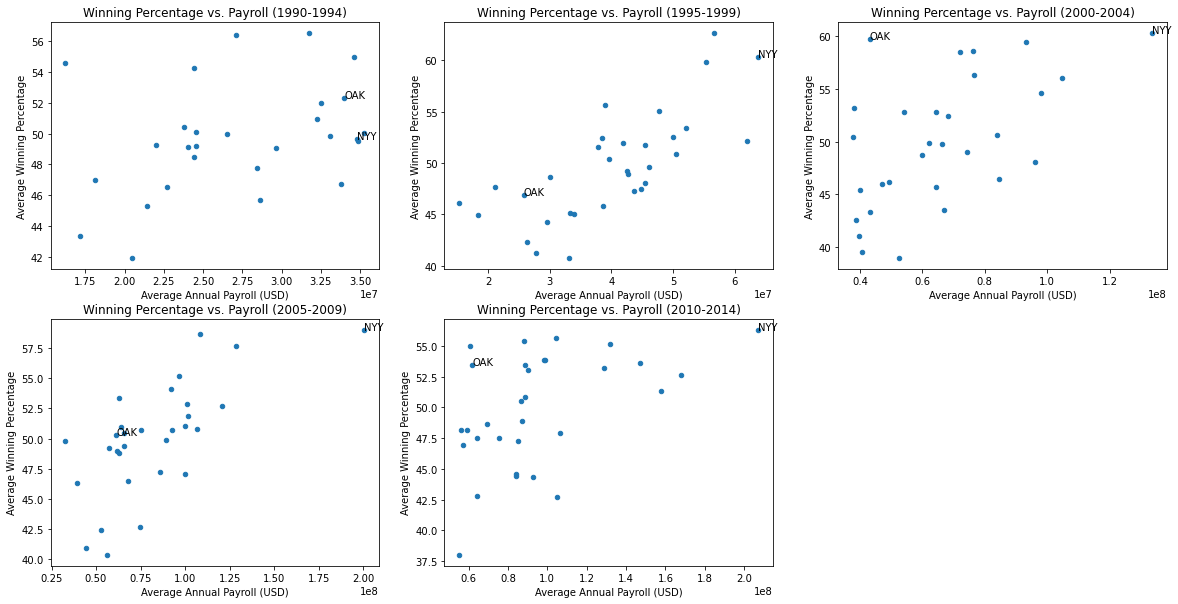

In [17]:
# creates 5 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.delaxes(axes[1][2])

# plots the data
means.loc["A"].plot.scatter(x="payroll", y="winPercent", ax=axes[0][0], title="Winning Percentage vs. Payroll (1990-1994)")
# adds a label "OAK" for the point representing the Oakland A's
axes[0, 0].text(means.loc["A"].at["OAK", "payroll"], means.loc["A"].at["OAK", "winPercent"], "OAK")
# adds a label "NYY" for the point representing the New York Yankees
axes[0, 0].text(means.loc["A"].at["NYA", "payroll"], means.loc["A"].at["NYA", "winPercent"], "NYY")

means.loc["B"].plot.scatter(x="payroll", y="winPercent", ax=axes[0][1], title="Winning Percentage vs. Payroll (1995-1999)")
axes[0, 1].text(means.loc["B"].at["OAK", "payroll"], means.loc["B"].at["OAK", "winPercent"], "OAK")
axes[0, 1].text(means.loc["B"].at["NYA", "payroll"], means.loc["B"].at["NYA", "winPercent"], "NYY")

means.loc["C"].plot.scatter(x="payroll", y="winPercent", ax=axes[0][2], title="Winning Percentage vs. Payroll (2000-2004)")
axes[0, 2].text(means.loc["C"].at["OAK", "payroll"], means.loc["C"].at["OAK", "winPercent"], "OAK")
axes[0, 2].text(means.loc["C"].at["NYA", "payroll"], means.loc["C"].at["NYA", "winPercent"], "NYY")

means.loc["D"].plot.scatter(x="payroll", y="winPercent", ax=axes[1][0], title="Winning Percentage vs. Payroll (2005-2009)")
axes[1, 0].text(means.loc["D"].at["OAK", "payroll"], means.loc["D"].at["OAK", "winPercent"], "OAK")
axes[1, 0].text(means.loc["D"].at["NYA", "payroll"], means.loc["D"].at["NYA", "winPercent"], "NYY")

means.loc["E"].plot.scatter(x="payroll", y="winPercent", ax=axes[1][1], title="Winning Percentage vs. Payroll (2010-2014)")
axes[1, 1].text(means.loc["E"].at["OAK", "payroll"], means.loc["E"].at["OAK", "winPercent"], "OAK")
axes[1, 1].text(means.loc["E"].at["NYA", "payroll"], means.loc["E"].at["NYA", "winPercent"], "NYY")

plt.setp(axes, xlabel="Average Annual Payroll (USD)")
# added "_ =" for clean output
_ = plt.setp(axes, ylabel="Average Winning Percentage")

To create the 5 plots, I first used the `groupby()` function in Pandas to group the data by chunks of time and team, and take the mean payroll and winning percentage for teams in each. I chose the 5 groups that I did (between 1990-2014) because each time chunk is equal, and we can compare results with results in problems 2 and 3. I then plotted the values for teams within each time chunk on 5 different plots. I chose to label two teams on the plots to make analysis easier. The Oakland A's are labeled "OAK", and the New York Yankees are labeled "NYY".

I chose these teams becase the A's are known having used analytics to win while spending less than other teams, while the Yankees are known for spending a lot of money (also becase I am a Yankees fan). Both of these teams don't rename or move in 1990-2014, so they are in all 5 plots.

### Question 2

Before analyzing what these plots show, it's important to notice that the x-axis is not consistent for all of them. There seems to a general trend of all teams spending more money over time, which is most prevalent between 1990-1994 and 1995-1999. In 1990-1994 the highest spending teams were around a average annual payroll of \\$35 million—in 1995-1999 there were many teams above \\$40 million, and the highest spending teams were around \\$6 million.

In general, it's easy to see a slight trend upward in most of these graphs, meaning teams that spend more money tend to have a higher winning percentage. It is not until 2010-2014 that you begin to see many teams be near the top in winning percentage that are on the lower end of the league in terms of average annual payroll.

The first thing I noticed when looking at these graphs is the Yankees' increase in spending between 1995-1999 and 2005-2009. In the former their average payroll appears to be around \\$65 million a year, whereas in the latter it is around \\$200 million, and by then the Yankees have really become an outlier in spending. In the case of the Yankees, this does seem to translate into winning games, because their winning percentage is at or is very near the highest in the league for all three time chunks following their initial spending increase.

The first graph shows that the A's in 1990-1994 had one of the highest average annual payrolls in the MLB. However, in 1995-1999 their spending had not increased by nearly as much as other teams in the league, and they had one of the lowest average payrolls; their success seemed to reflect that, their winning percentage was below 50\% and was pretty low compared to most other teams over that span. In 2000-2004 their average payroll was still one of the lowest in the league but their winning percentage was one of the best—almost tied with the Yankees! Something must have happened around the turn of the millennium that helped the A's win games with much less money than other teams.

They remained low spenders relative to other teams in the next two time chunks, but always had a winning record on average (winning percent over 50\%). In 2005 to 2009 their winning percentage was only mediocre, but in 2010-2014 they were back to being near the top of the league.

# Part 3: Data transformations

## Standardizing Across Years

### Problem 5